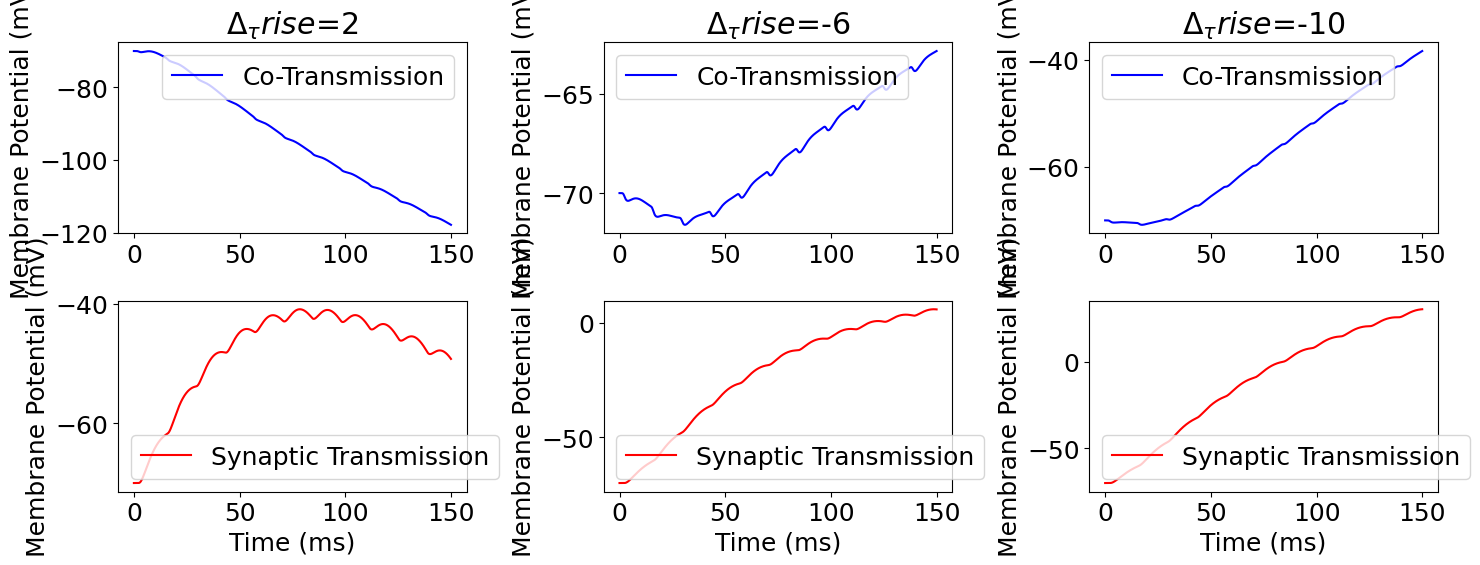

In [1]:
####### SOMA/DENDRITE COMPARTMENTS IN CORTICAL NEURONS

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"

delay=0
count=0
plt.figure(figsize=(15,6))

width_block=1
frequency = 120 #Hz


for a in [10]:#np.arange(1,10,10):

    for b in [8,16,20]:#np.arange(1,10,2):

        g_AMPA_ext_E = 1#100.08 #nS
        tau_1 = a #ms
        tau_2 = 5 #ms

        g_GABA_E = 1.2 #nS
        tau_1g = b #10. #ms
        tau_2g=2

        t = 150
        
        dt = 0.1
        N = round(t/dt)
        ttotal = np.arange(0,t,dt)

        ## signal
        tspks = np.linspace(0,t,int(frequency/10))
        tspksi = [int(x/dt) for x in tspks]
        tspksf = [int((x+width_block)/dt) for x in tspks]
        amp=1
        syn = np.zeros_like(ttotal)
        for i in range(len(tspksi)):
            syn[tspksi[i]:tspksf[i]]=amp

        lat_e=1
        syn_ampa = np.zeros_like(ttotal)
        for o in range(len(tspksi)):
            syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

        lat_i=2
        syn_gaba = np.zeros_like(ttotal)
        for o in range(len(tspksi)):
            syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

        s_AMPA=0
        x_ampa=0

        s_GABA=0
        x_gaba=0

        Iacum_AMPA = []
        Iacum_GABA = []
        IacumCo =[ ]

        sg =[]
        sa = []

        ####neuron parameters
        v_soma = -70
        v_dend = -70
        gleak_soma = 1*(10**-4)
        gleak_dend = 1*(10**-4)
        Eleak_soma = -70
        Eleak_dend = -70
        vacum_soma = []
        vacum_dend = []

        ####second neuron
        v_soma2 = -70
        v_dend2 = -70
        vacum_soma2 = []
        vacum_dend2 = []

        ####Coupling parameters
        g_coupling = 0.01  # coupling conductance
        

        for i in range(N):
            #vpre ---> I -> vpost

            s_AMPA = s_AMPA + dt*( ((tau_2/tau_1) ** (tau_1 / (tau_2 - tau_1))*x_ampa-s_AMPA)/tau_1 )
            x_ampa = x_ampa + dt*(-x_ampa/tau_2 + syn_ampa[i])
            Iacum_AMPA.append(-s_AMPA)

            s_GABA = s_GABA + dt*( ((tau_2g/tau_1g) ** (tau_1g / (tau_2g - tau_1g))*x_gaba-s_GABA)/tau_1g )
            x_gaba = x_gaba + dt*(-x_gaba/tau_2g + syn_gaba[i])
            Iacum_GABA.append(s_GABA)
            
            IacumCo.append(s_GABA-s_AMPA)

            #### current for soma
            Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

            #### Ccurrent for dendrite
            Ileak_dend = gleak_dend * (v_dend - Eleak_dend)

            #### doupling durrent
            I_coupling = g_coupling * (v_soma - v_dend)

            #### total current for soma and dendrite
            I_total_soma =  - Ileak_soma - I_coupling + IacumCo[-1] #Iacum_GABA[-1] + Iacum_AMPA[-1]
            I_total_dend = - Ileak_dend + I_coupling

            #### update membrane potentials
            v_soma = v_soma + dt * I_total_soma
            v_dend = v_dend + dt * I_total_dend

            vacum_soma.append(v_soma)
            vacum_dend.append(v_dend)

            #### total current for soma and dendrite second neuron
            Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
            Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
            I_coupling = g_coupling * (v_soma2 - v_dend2)
            I_total_soma =  - Ileak_soma - I_coupling + Iacum_GABA[-1] 
            I_total_dend = - Ileak_dend + I_coupling + Iacum_AMPA[-1]

            #### update membrane potentials
            v_soma2 = v_soma2 + dt * I_total_soma
            v_dend2 = v_dend2 + dt * I_total_dend

            vacum_soma2.append(v_soma2)
            vacum_dend2.append(v_dend2)

        peaks_AMPA, _ = find_peaks(Iacum_AMPA)
        peaks_GABA, _ = find_peaks(Iacum_GABA)

        Iacum_AMPA = np.asarray(Iacum_AMPA)
        Iacum_GABA = np.asarray(Iacum_GABA)

        filtered_signal_AMPA = gaussian_filter1d(Iacum_AMPA[peaks_AMPA], 4)
        filtered_signal_GABA = gaussian_filter1d(Iacum_GABA[peaks_GABA], 4)

        count = count + 1
       
        plt.subplot(2, 3, count)# + 3)
        
        plt.title(r'$\Delta_\tau rise$' + f'={tau_1-tau_1g}')
       
        
        plt.plot(ttotal, vacum_soma, label='Co-Transmission', c='b')
        plt.legend()
        plt.ylabel('Membrane Potential (mV)')

        plt.subplot(2, 3, count+3)
        plt.plot(ttotal, vacum_soma2,label='Synaptic Transmission', c='r')
        
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.legend()
        plt.tight_layout()

plt.savefig('compartments.png')
plt.savefig('compartments.pdf')
plt.show()

g_coupling: 0.01, RMSE: 42.32818276460889
g_coupling: 0.0325, RMSE: 15.509657853287518
g_coupling: 0.05500000000000001, RMSE: 9.424060997364439
g_coupling: 0.0775, RMSE: 6.77018120654218
g_coupling: 0.1, RMSE: 5.285892109482664


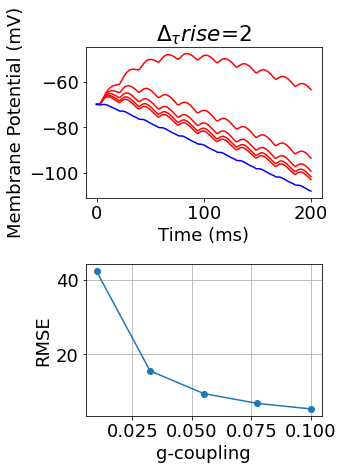

In [115]:
####### SOMA/DENDRITE COMPARTMENTS IN CORTICAL NEURONS

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

def calculate_rmse(signal1, signal2):
    return np.sqrt(np.mean((np.array(signal1) - np.array(signal2)) ** 2))

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"

delay=0

plt.figure(figsize=(5,6))


width_block=1
frequency = 120 #Hz

g_coupling_values = np.linspace(0.01, 0.1, 5)  


rmse_values = []


for a in [10]:
    for b in [8]:

        

        
        count=0

        for g_coupling in g_coupling_values:    

            g_AMPA_ext_E = 1 #nS
            tau_1 = a #ms
            tau_2 = 5 #ms

            g_GABA_E = 1.2 #nS
            tau_1g = b  #ms
            tau_2g=2

            t = 200
            dt = 0.1
            N = round(t/dt)
            ttotal = np.arange(0,t,dt)

            ## signal
            tspks = np.linspace(0,t,int(frequency/10))
            tspksi = [int(x/dt) for x in tspks]
            tspksf = [int((x+width_block)/dt) for x in tspks]
            amp=1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]]=amp

            lat_e=1
            syn_ampa = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

            lat_i=2
            syn_gaba = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

            s_AMPA=0
            x_ampa=0

            s_GABA=0
            x_gaba=0

            Iacum_AMPA = []
            Iacum_GABA = []
            IacumCo =[ ]

            sg =[]
            sa = []

            ####neuron parameters
            v_soma = -70
            v_dend = -70
            gleak_soma = 1*(10**-4)
            gleak_dend = 1*(10**-4)
            Eleak_soma = -70
            Eleak_dend = -70
            vacum_soma = []
            vacum_dend = []

            ####second neuron
            v_soma2 = -70
            v_dend2 = -70
            vacum_soma2 = []
            vacum_dend2 = []


            for i in range(N):
                #vpre ---> I -> vpost

                s_AMPA = s_AMPA + dt*( ((tau_2/tau_1) ** (tau_1 / (tau_2 - tau_1))*x_ampa-s_AMPA)/tau_1 )
                x_ampa = x_ampa + dt*(-x_ampa/tau_2 + syn_ampa[i])
                Iacum_AMPA.append(-s_AMPA)

                s_GABA = s_GABA + dt*( ((tau_2g/tau_1g) ** (tau_1g / (tau_2g - tau_1g))*x_gaba-s_GABA)/tau_1g )
                x_gaba = x_gaba + dt*(-x_gaba/tau_2g + syn_gaba[i])
                Iacum_GABA.append(s_GABA)
                
                IacumCo.append(s_GABA-s_AMPA)

                #### ionic current for soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                #### ionic current for dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)

                #### coupling current
                I_coupling = g_coupling * (v_soma - v_dend)

                #### total current for soma and dendrite
                I_total_soma =  - Ileak_soma - I_coupling + IacumCo[-1] 
                I_total_dend = - Ileak_dend + I_coupling

                #### update membrane potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend

                vacum_soma.append(v_soma)
                vacum_dend.append(v_dend)

                #### total current for soma and dendrite second neuron
                Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
                Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
                I_coupling = g_coupling * (v_soma2 - v_dend2)
                I_total_soma =  - Ileak_soma - I_coupling + Iacum_GABA[-1] 
                I_total_dend = - Ileak_dend + I_coupling + Iacum_AMPA[-1]

                #### update membrane potentials
                v_soma2 = v_soma2 + dt * I_total_soma
                v_dend2 = v_dend2 + dt * I_total_dend

                vacum_soma2.append(v_soma2)
                vacum_dend2.append(v_dend2)

            peaks_AMPA, _ = find_peaks(Iacum_AMPA)
            peaks_GABA, _ = find_peaks(Iacum_GABA)

            Iacum_AMPA = np.asarray(Iacum_AMPA)
            Iacum_GABA = np.asarray(Iacum_GABA)

            filtered_signal_AMPA = gaussian_filter1d(Iacum_AMPA[peaks_AMPA], 4)
            filtered_signal_GABA = gaussian_filter1d(Iacum_GABA[peaks_GABA], 4)

            

            plt.subplot(2, 1, count+1)# + 3)
            
            plt.title(r'$\Delta_\tau rise$' + f'={tau_1-tau_1g}')

            # plt.xlabel('Time (ms)') 
            
            
            plt.plot(ttotal, vacum_soma2,label='Synaptic Transmission', c='r')
            
            plt.xlabel('Time (ms)')
            plt.ylabel('Membrane Potential (mV)')
            # plt.legend()

            # RMSE bw soma and dendrite membrane potentials
            rmse = calculate_rmse(vacum_soma, vacum_soma2)
            rmse_values.append(rmse)
            

            plt.tight_layout()
        plt.plot(ttotal, vacum_soma, label='Co-transmission', c='b')
        plt.subplot(2, 1, count + 2)
        plt.plot(g_coupling_values, rmse_values, marker='o')
        plt.xlabel('g-coupling')
        plt.ylabel('RMSE')
        count = count + 1

plt.grid(True)

plt.savefig('variation_'+str(b)+'.png')
plt.savefig('variation_'+str(b)+'.pdf')
   
plt.show()

In [85]:
rmse_values

[5.285892109482537]